In [72]:
# #자동 Reload
# %load_ext autoreload
# %autoreload 2 # 실행하기 전에 항상 모든 모듈을 Reload

# **필수 구성 요소 Python 모듈**

먼저 일부 소프트웨어를 Python 환경에 로드해야 합니다.

In [1]:
import tensorflow as tf
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
from tensorflow.keras.models import Sequential  # Model type to be used
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout, Activation
from tensorflow.keras.utils import to_categorical, plot_model

print(tf.__version__) # find the version number (should be 2.x+)

# 그래픽카드 유무 확인 및 메모리 확장 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print('사용가능한 GPU 갯수: ',len(gpus), '\n')
      
  try:
    # 프로그램이 실행되어 더 많은 GPU 메모리가 필요하면, 텐서플로 프로세스에 할당된 GPU 메모리 
    # 영역을 확장할 수있도록 허용
    tf.config.experimental.set_memory_growth(gpus[0], True)

  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

# 설치된 GPU 상세내용 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.6.0
사용가능한 GPU 갯수:  1 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17975472070767607948
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16741363515970774097
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# **Dataset**

[Fashion MNIST Github Repo](https://github.com/zalandoresearch/fashion-mnist)

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

패션 아이템의 그레이스케일 이미지가 주어진 경우 10개의 다른 클래스에서 클래스를 예측합니다.<br> 각 이미지는 하나의 항목만 포함하므로 다중 클래스 분류 문제입니다.

분류 문제 유형:

* BInary - 상호 배타적인 두 결과 사이를 예측합니다. (스팸 또는 스팸 아님, 비 또는 비 없음, 긍정적 정서 또는 부정적 정서)
* Multiclass - 상호 배타적인 결과 n개를 예측합니다. (위 문제, 맑음, 비, 바람)
* Multilabel - 각각 n개의 결과가 동시에 발생할 수 있음을 예측합니다(자연 설정 이미지에서 개체 탐지, 웹 페이지/기사의 태그).

In [2]:
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and testing sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Name of the classes
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n_classes = len(class_names)
print('Number of classes: ', n_classes)

4431872/4422102 [==============================] - 0s 0us/step
Number of classes:  10


In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [4]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

참고:

* 교육 세트에 60000개의 이미지와 테스트 세트에 10000개의 이미지가 있습니다.
* 이미지 치수는 28x28(그레이스케일, 모든 치수가 동일)입니다.
* 레이블은 class_names에 매핑이 있는 0-9의 정수 값입니다.

# **Exploratory Data Analysis**
탐색 데이터 분석

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Train labels:  {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


<BarContainer object of 10 artists>

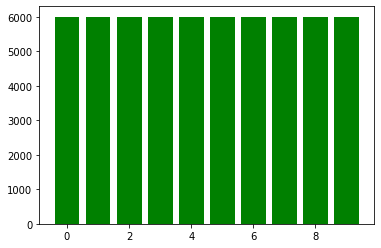

In [5]:
# Exploratory Data Analysis (EDA)

# count and plot the number of unique train labels
print(np.unique(y_train))
unique, counts = np.unique(y_train,return_counts=True)
print(unique)
print(counts)
y_train_dist = dict(zip(unique, counts))
print("Train labels: ", y_train_dist)
plt.bar(y_train_dist.keys(), y_train_dist.values(), color='g')

Test labels:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


<BarContainer object of 10 artists>

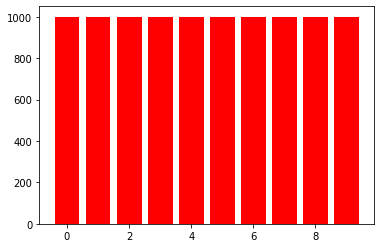

In [6]:
# count and plot the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
y_test_dist = dict(zip(unique, counts))
print("Test labels: ", y_test_dist)
plt.bar(y_test_dist.keys(), y_test_dist.values(), color='r')

분포는 데이터의 클래스 간에도 균등하게 분포되어 있습니다! :)

In [7]:
# Plot 25 randomly selected images from train or test dataset
# 데이터 집합에서 무작위로 선택한 이미지 25개를 플롯
def random_view(images_dataset, labels_dataset, train=True):

  indexes = np.random.randint(0, images_dataset.shape[0], size=25)

  images = x_train[indexes]
  labels = y_train[indexes]

  print(len(indexes))
  # plot the 25 mnist digits
  plt.figure(figsize=(10,10))
  title = "Random Images from Train Dataset" if train else "Random Images from Test Dataset\n"
  plt.suptitle(title, fontsize=16, y=1.08)
  for i in range(len(indexes)):
      plt.subplot(5, 5, i + 1)
      image = images[i]
      plt.imshow(image, cmap='gray')
      plt.title('label: {}'.format(class_names[labels[i]]))
      plt.tight_layout()
      plt.axis('off')

  print("\n\n")

25





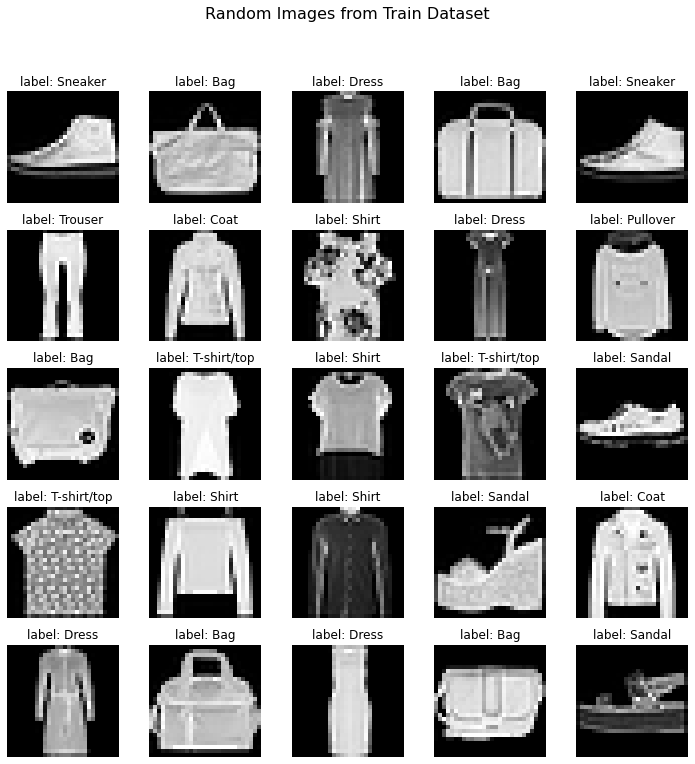

In [8]:
random_view(x_train, y_train, True)

25





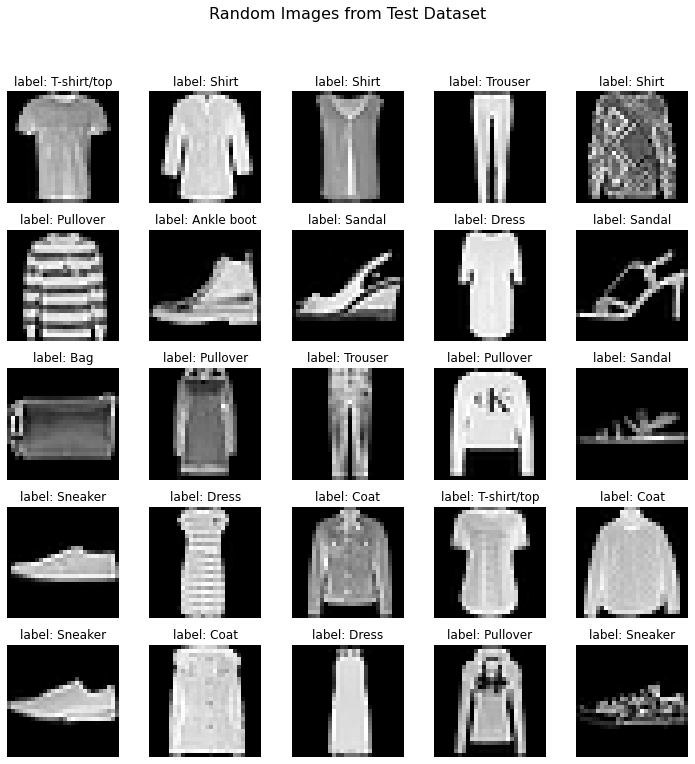

In [9]:
# Plot 25 randomly selected images from test dataset
random_view(x_test, y_test, False)

## View multiple random images from train/test dataset.

In [10]:
# Randomly sample n * n images from train or test dataset

import pandas as pd
import numpy as np
def plot_images(n, train=True):
    """
    학습 또는 테스트 데이터 집합에서 무작위로 선택한 n*n개의 이미지
    n: 그림에 대한 열 수(n x n 하위 그림)
    Assume: 학습 데이터 = (x_train, y_train)
            검정 데이터 = (x_test, y_test)
    """
    
    if train :
        indexes = np.random.randint(0, x_train.shape[0], size = n * n)
        images = x_train[indexes]
        labels = y_train[indexes]
    else:
        indexes = np.random.randint(0, x_test.shape[0], size = n*n)
        images = x_test[indexes]
        labels = y_test[indexes]

    # plot the n by n images
    plt.figure(figsize = (7, 7))
    title = 'Random Images from Train Dataset' if train else 'Random Images from Test Dataset\n'
    plt.suptitle(title, fontsize = 16, y = 1.08)
    for i in range(len(indexes)):
        plt.subplot(n, n, i+1)
        image = images[i]
        plt.imshow(image, cmap = 'gray')
        # plt.title('label : ', class_names[labels[i]])
        plt.title('label: {}'.format(class_names[labels[i]]))

        plt.tight_layout()
        plt.axis('off')        

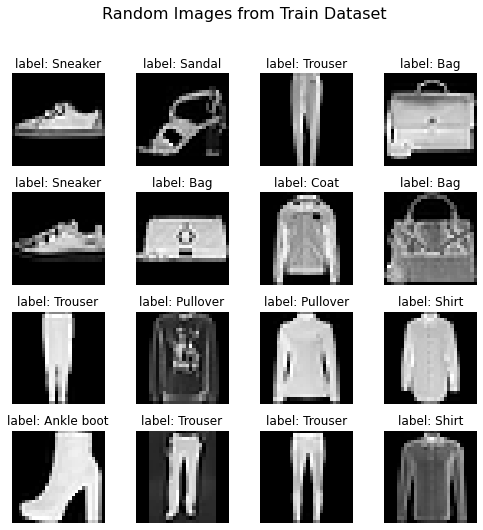

In [11]:
# plt random images from train dataset
plot_images(4)

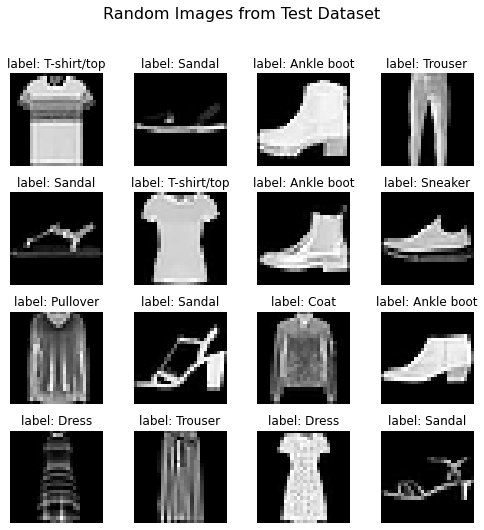

In [12]:
# plot random images from test dataset 
plot_images(4, train=False)

In [13]:
def plot_images_by_class(n, category=0):
    """
    주어진 범주에서 n개의 랜덤 학습 이미지를 flot합니다.
    Assume: 학습 데이터 = (x_train, y_train)
            검정 데이터 = (x_test, y_test)          
    """

    len = 6000  # sample size in each category = 6000
    indexes = np.where(y_train==category)
    indexes = np.asarray(indexes).reshape(len) 
    chosen = np.random.randint(0, len, size=n*n)

    plt.suptitle("Random Images in "+ class_names[category], fontsize=16, y=1.08)
    plt.figure(figsize=(7,7))
    for i in range(n*n):
        plt.subplot(n, n, i + 1)
        image = x_train[indexes[chosen[i]]]
        label = y_train[indexes[chosen[i]]]
        plt.imshow(image, cmap='gray')
        plt.title('label: {}'.format(class_names[label]))
        plt.tight_layout()
        plt.axis('off')

<Figure size 432x288 with 0 Axes>

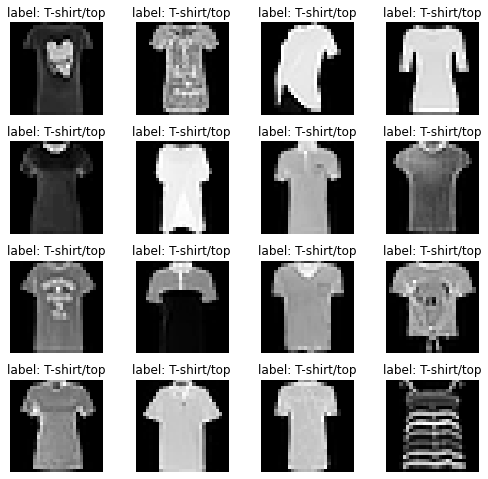

In [14]:
plot_images_by_class(4)

# **Cross-entropy**
딥러닝에서 분류 모델에 대한 손실 함수로 cross-entropy 혹은 binary entropy 나 log loss 라는 것을 사용하게 된다.<br> 손실함수로서의 cross-entropy 는 아래 식으로 계산할 수 있다.

$$-\frac{1}{n} \sum_{i=1}^{n}\sum_{c=1}^{C} y_{ic}log(\hat y_{ic})$$
 
여기서, 

$n = $ 데이터 갯수

$C = $ 범주 갯수

$y = $ 실제 값(one-hot 인코딩 형태의 정답) (주로 0 또는 1)

$\hat y = $ 딥러닝 모델의 예측값(확률값) (0~1)  

<br>예를 들어 $C = 3$일 때 두 특정 샘플 $y_1 = [0, 0, 1] $,  $\hat y_1 = [0.1, 0.2, 0.7]$, $y_2 = [0, 0, 1] $,  $\hat y_2 = [0.5, 0.3, 0.2]$라 하자. 
<br><br>이 때,  샘플 1의 경우  cross entropy 는 
$$ 0*log(0.1) + 0*log(0.2) + 1*log(0.7) = -log(0.7) = 0.35 $$ 
<br>
샘플 2의 경우 예측 모델은 상당히 잘못 예측했다는 것을 알 수 있고,
<br>이 경우 cross entropy 는  
$$ -log(0.2) = 1.6$$ 


딥러닝을 통한 예측 모델링에 있어,<br> cross-entropy가  실제 값과 예측값의 차이(error 혹은 loss)로서의 의미를 가지게 된다는 것을 직관적으로 이해할 수 있다.  

더 자세한 사항을 공부하려면 github에 올려논 [A Gentle Introduction to Cross-Entropy for Machine Learning](https://github.com/sangsin/Introduction-to-Deep-Learning-with-Tensorflow-2.0-and-Keras/blob/main/Lecture%2005~07%20-%20Classification/A%20Gentle%20Introduction%20to%20Cross-Entropy%20for%20Machine%20Learning.ipynb)
을 참고할 것

## **Softmax Activation Function**

Softmax(소프트맥스)는 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수이다.

  - Softmax는 세개이상으로 분류하는 다중클래스 분류(Multi-class Classification)에서 사용되는 활성화 함수이다.
  - 분류하고 싶은 클래수가 c개라고 할때 c by 1 벡터를 입력받아, 각 클래스에 속할 확률을 출력한다.
  - 가장 큰 출력 값을 부여받은 클래스가 확률이 가장 높은 것으로 이용된다.

입력벡터를 $z = [z_1, z_2, \cdots, z_c]$일때

  $$\hat y_k = \frac{e^{z_k}}{\sum_{i=1}^{c} e^{z_i}}$$

  



In [15]:
import numpy as np

# calculate the softmax of a vector
def softmax(vector):
    e = np.exp(vector) #  밑이 자연상수 e인 지수함수(e^x)로 변환
    return e / e.sum()
 
# define data
data = [1, 3, 2]
# convert list of numbers to a list of probabilities
# # 숫자 목록을 확률 목록으로 변환
result = softmax(data)
# report the probabilities
# 확률
print(result)
# report the sum of the probabilities
# 확률의 합계
print('Sum = ',sum(result))
print('Class =',np.argmax(result))

[0.09003057 0.66524096 0.24472847]
Sum =  1.0
Class = 1


# **Build a multiclass classification model**
다중 클래스 분류 모델 작성

* Loss function = `CategoricalCrossentropy` (if one-hot) else `SparseCategoricalCrossentropy`
* Output activation = `Softmax`
* Input shape = 28x28 (shape of one image)
* Output shape = 10 (1 per class)

In [25]:
from tensorflow.keras import layers, losses, optimizers
from sklearn.metrics import classification_report


from tensorflow.keras.models import Sequential  # Model type to be used
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Activation
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and testing sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Name of the classes
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n_classes = len(class_names)
print('Number of classes: ',n_classes)

Number of classes:  10


# **Get one hot encoded labels**

In [26]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

# **Scale the images**
이미지는 8비트 단일 채널 이미지입니다. (따라서 픽셀 값은 between $0$ and $2^8 - 1 = 255$ )

In [27]:
x_train, x_test = x_train/255.0, x_test/255.0
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

# **The Flatten layer**

* dim(28, 28)의 이미지를 간단한 Deep Neural Network에 전달하기 전에 이미지를 평평하게 만들어야 합니다.
* 그럼 신경망 층을 평소처럼 만들 수 있겠군
* 이로 인해 공간 상관 속성이 느슨해지고 모델은 일부 픽셀이 공간적으로 서로 더 가깝다는 징조를 얻을 수 없습니다.

In [28]:
# 28 * 28
input_dim = x_train.shape[1]*x_train.shape[2]
flatten_model = tf.keras.models.Sequential([
    Flatten(input_dim=input_dim)
])

# In ther ways, use 'reshape'


x_train = x_train.reshape(60000, input_dim) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
x_test = x_test.reshape(10000, input_dim)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

The flatten layer flattens a (28, 28) into 784 (1-D) vector

# **Model 1: Simple Deep Neural Network**

- 대상이 단일 핫 인코딩인 경우 categal_crossentropy를 사용합니다.
  > 
  > [1,0,0]
  >
  > [0,1,0]
  > 
  > [0,0,1]
  >
  - 그러나 대상이 정수인 경우 sparse_categorical_crossentropy를 사용하십시오.
  > 
  > [1, 2, 3]
  > 

  - Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).

Link: [Sparse_categorical_crossentropy vs categorical_crossentropy (keras, accuracy)](https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy)


In [29]:
# Set random seed
tf.random.set_seed(42)

# Create model
model = tf.keras.models.Sequential([
    Flatten(input_shape = (input_dim,)),
    Dense(128, activation='relu'),
    Dense(4, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=0.001), metrics='accuracy')

# Fit the model
history = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=1) # 128 batch size works faster!


Epoch 1/20
422/422 [==============================] - 4s 4ms/step - loss: 1.0462 - accuracy: 0.6279 - val_loss: 0.6257 - val_accuracy: 0.8020
Epoch 2/20
422/422 [==============================] - 2s 4ms/step - loss: 0.5305 - accuracy: 0.8252 - val_loss: 0.4752 - val_accuracy: 0.8373
Epoch 3/20
422/422 [==============================] - 2s 4ms/step - loss: 0.4519 - accuracy: 0.8476 - val_loss: 0.4346 - val_accuracy: 0.8502
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.4083 - accuracy: 0.8589 - val_loss: 0.4104 - val_accuracy: 0.8548
Epoch 5/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3809 - accuracy: 0.8670 - val_loss: 0.4006 - val_accuracy: 0.8582
Epoch 6/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3595 - accuracy: 0.8731 - val_loss: 0.3939 - val_accuracy: 0.8615
Epoch 7/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3444 - accuracy: 0.8784 - val_loss: 0.3689 - val_accuracy: 0.8665
Epoch 

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50        
Total params: 101,046
Trainable params: 101,046
Non-trainable params: 0
_________________________________________________________________


## Evaluate the above model

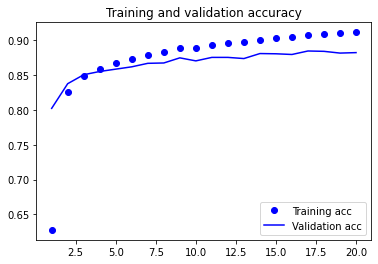

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot learning curves for accuracy

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

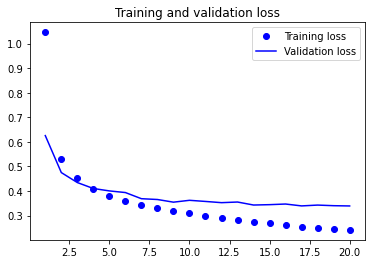

In [32]:
# Plot learning curves for accuracy

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

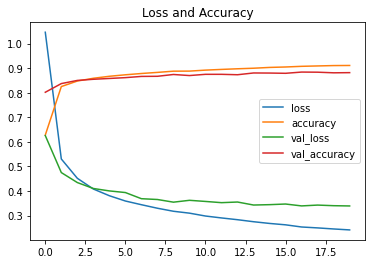

In [33]:
# Alternative Method

import pandas as pd
pd.DataFrame(history.history).plot(title="Loss and Accuracy")

모델이 더 이상 패턴을 배우지 않고 부족한 것 같습니다. 각 층에 있는 뉴런의 수를 늘리면 어떨까?

## Test Loss and Test Accuracy

In [35]:
# accuray and loss using test images
loss, accuracy = model.evaluate(x_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3699 - accuracy: 0.8705
Test loss: 0.3699144721031189
Test accuracy: 0.8705000281333923


# **Model 2: Simple Deep Neural Network - 2layer - larger**

In [36]:
# The data has already been sorted into training and testing sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)

# Flatten image data in order to be used as a dense layer input 
x_train = x_train.reshape(60000, input_dim) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
x_test = x_test.reshape(10000, input_dim)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

# Scaling
x_train, x_test = x_train/255.0, x_test/255.0

# One-hot encoding for labels
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [38]:
# set seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    layers.Flatten(input_dim = input_dim),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(1e-3), metrics='accuracy')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
_________________________________________________________________


## Model Fit

In [39]:
# Fit the model
history = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=1)

Epoch 1/20
422/422 [==============================] - 2s 4ms/step - loss: 0.5720 - accuracy: 0.8017 - val_loss: 0.4301 - val_accuracy: 0.8487
Epoch 2/20
422/422 [==============================] - 2s 4ms/step - loss: 0.4085 - accuracy: 0.8550 - val_loss: 0.3813 - val_accuracy: 0.8645
Epoch 3/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3649 - accuracy: 0.8687 - val_loss: 0.3798 - val_accuracy: 0.8640
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3366 - accuracy: 0.8779 - val_loss: 0.3675 - val_accuracy: 0.8677
Epoch 5/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3213 - accuracy: 0.8828 - val_loss: 0.3365 - val_accuracy: 0.8768
Epoch 6/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3038 - accuracy: 0.8884 - val_loss: 0.3543 - val_accuracy: 0.8718
Epoch 7/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2910 - accuracy: 0.8934 - val_loss: 0.3328 - val_accuracy: 0.8778
Epoch 

## Plot learning curve

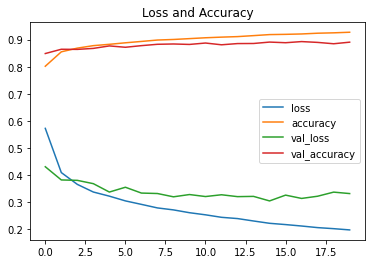

In [40]:
# Alternative Method

import pandas as pd
pd.DataFrame(history.history).plot(title="Loss and Accuracy")

뉴런이 더 추가되면서 우리 모델이 조금 나아졌는데 OverFit은 아닌 것 같아!

# **Confusion Matric**

In [41]:
# Confusion Matrix

# Get predicted class for X_test by converting all of the predictions from probabilities to labels
y_probs = model.predict(x_test)
#print(tf.argmax(pred[0:10]))
print(y_probs[0:10])

y_pred=y_probs.argmax(axis=1)

print('Predicted class probability\n',y_pred[0:10])
print('One-hot encoded labels\n',y_test[0:10])

# To compare y_pred with y_test, y_test should be decoded as a vector.
labels = y_test.argmax(axis=1)
print('Decoded labels\n',labels[0:10])

# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=labels, y_pred=y_pred)
cm = pd.DataFrame(cm)
cm['sum']= cm.sum(axis=1)
cm.loc['Total']= cm.sum()
cm

[[3.1129007e-06 1.2896522e-11 8.6869295e-07 8.9183294e-07 5.3040892e-09
  9.2600344e-04 2.0504704e-05 7.0549087e-03 1.2235643e-07 9.9199355e-01]
 [4.7420741e-05 1.5829521e-14 9.9936086e-01 5.5831258e-08 5.6369213e-04
  2.6417445e-14 2.7991022e-05 2.1327896e-11 8.1061540e-09 3.8328772e-12]
 [2.4736993e-10 1.0000000e+00 1.2324182e-12 9.3236852e-10 2.4494386e-11
  3.8246681e-17 1.1414116e-10 7.2714220e-22 8.7710030e-12 1.0945944e-18]
 [2.8993128e-08 9.9999988e-01 1.2147226e-10 1.7817683e-07 2.6711748e-09
  7.6029061e-14 4.7943573e-08 9.2135771e-19 2.1156409e-10 5.5408851e-15]
 [1.7297533e-01 2.2655982e-08 7.1261195e-03 2.0131672e-04 1.8399900e-03
  1.6600164e-10 8.1785333e-01 9.5703392e-09 3.7172629e-06 5.8294596e-08]
 [3.7285901e-07 9.9999845e-01 2.0187807e-08 5.7028797e-07 7.7926487e-08
  3.1298317e-13 4.7354746e-07 9.5138476e-16 5.6978182e-09 4.5784885e-14]
 [2.1637867e-07 4.5192428e-05 2.6917694e-05 2.0394323e-06 9.9930251e-01
  3.0590022e-10 6.2250887e-04 9.7737839e-11 6.3323432e-07 

,0,1,2,3,4,5,6,7,8,9,sum
0,848,3,17,20,3,1,100,0,8,0,1000
1,4,978,0,11,4,0,3,0,0,0,1000
2,25,2,753,14,117,0,89,0,0,0,1000
3,30,7,11,885,41,1,21,0,4,0,1000
4,2,1,70,20,838,0,68,0,1,0,1000
5,0,0,0,0,0,958,0,34,1,7,1000
6,147,1,55,27,57,0,704,0,9,0,1000
7,0,0,0,0,0,9,0,973,0,18,1000
8,9,0,0,5,5,2,5,4,970,0,1000
9,0,0,0,0,0,18,1,49,0,932,1000



      0 : T-shirt/top 
      1 : Trouser
      2 : Pullover
      3 : Dress
      4 : Coat
      5 : Sandal
      6 : Shirt
      7 : Sneaker
      8 : Bag
      9 : Ankle boot


In [42]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

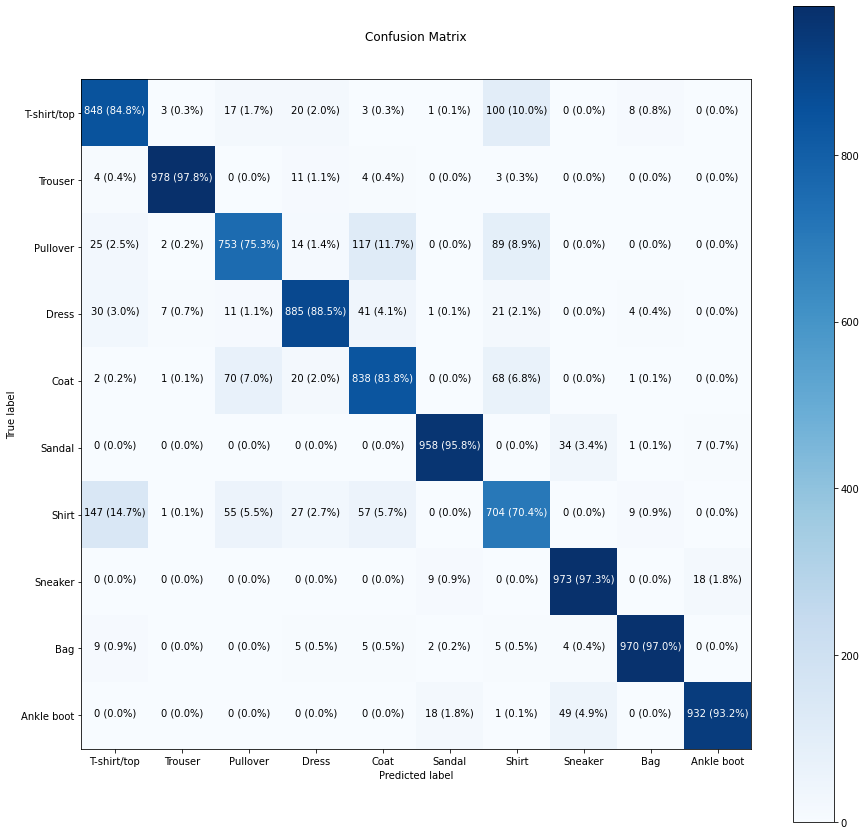

In [43]:
# Make a prettier confusion matrix

#class_names=[str(i) for i in range(0,10)]
make_confusion_matrix(y_true=labels, 
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

# **Precision, Recall, and F1-score**

In [44]:
# Let's consider the classification results for digit '1',

TP  = cm.iat[0,0]
FN = cm.iat[0, 10]-TP
FP = cm.iat[10, 0]-TP

precision = TP/(TP +FP)
recall = TP/(TP +FN)
F1 = 2*(precision*recall)/(precision+recall)

print("True Positive = {},  False Negative =  {},  False Positive = {}".format(TP,FN,FP))
print("\nPrecision = {:.4f},  Recall =  {:.4f},  F1 Score = {:.4f}".format(precision,recall,F1))

True Positive = 848,  False Negative =  152,  False Positive = 217

Precision = 0.7962,  Recall =  0.8480,  F1 Score = 0.8213


In [45]:
# Use sklearn classification_report.

from sklearn.metrics import classification_report
print(classification_report(labels, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7962    0.8480    0.8213      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8311    0.7530    0.7901      1000
           3     0.9012    0.8850    0.8930      1000
           4     0.7869    0.8380    0.8116      1000
           5     0.9687    0.9580    0.9633      1000
           6     0.7104    0.7040    0.7072      1000
           7     0.9179    0.9730    0.9447      1000
           8     0.9768    0.9700    0.9734      1000
           9     0.9739    0.9320    0.9525      1000

    accuracy                         0.8839     10000
   macro avg     0.8849    0.8839    0.8839     10000
weighted avg     0.8849    0.8839    0.8839     10000



## Inspecting FN/FP

출력을 검사하고 모든 것이 정상으로 보이는지 확인하는 것은 항상 좋은 생각입니다.<br> 여기서는 정답과 정답이 틀린 예를 살펴보겠습니다.

# **Visualize FN**

In [46]:
# 앞서데이터 전처리과정에서에서 우리는 28 by 28 이차원 이미지데이터 1차원 벡터로 Reshape 시켜놓았다. 
# 이미지 플로팅을 위해 우리는 다시 이미지를 이차원으로 변화 시킨다.

x_test = x_test.reshape(10000, 28,28) 

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot FN classified images

def show_FN(x_test,y_test, y_pred, true_class):

  dict = {'True Class': y_test,'Predicted Class':y_pred}
  df = pd.DataFrame(dict)
  df['row_num'] = df.index
  df = df[df['True Class']==true_class]
  df = df[df['True Class'] != df['Predicted Class']]
  n = df.shape[0] # sample size
  # print("Total Rows = ",n)
  # print(df)

  number_of_subplots=25 if n >= 26 else n
  rows = 5
  
  plt.figure(figsize=(10, 10))
  plt.suptitle("True Class: "+ class_names[true_class], fontsize=16, y=1.08)

 
  for i in range(number_of_subplots):
    ax = plt.subplot(rows, rows, i + 1)
    plt.imshow(x_test[df.iat[i,2]], cmap='gray')
    plt.title("Pred: {}".format(class_names[df.iat[i,1]]))
    plt.axis(False)

  # number_of_subplots=25 if n >= 36 else n

  # for i,v in enumerate(xrange(number_of_subplots)):
  #   v = v+1
  #   ax1 = subplot(number_of_subplots,1,v)
  #   plt.imshow(x_test[df.iat[i,2]], cmap='gray')
  #   plt.title("True: {} Pred: {} ".format(df.iat[i,0],df.iat[i,1]))
  #   plt.axis(False)

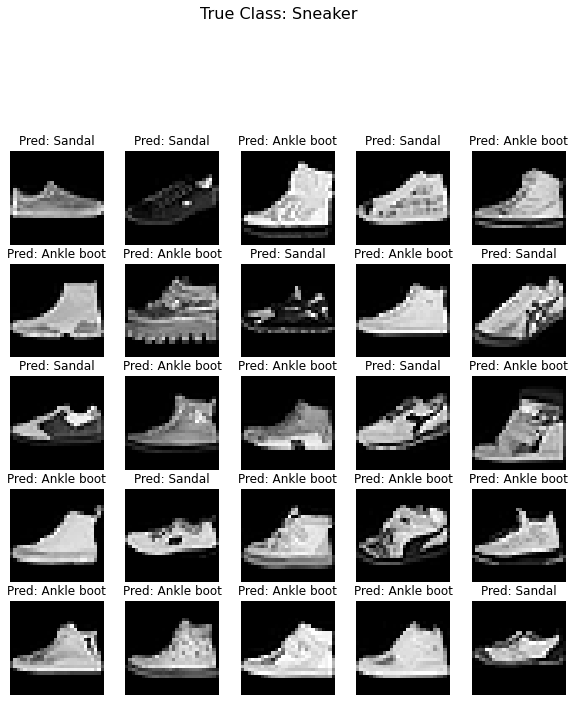

In [48]:
show_FN(x_test,labels, y_pred,7 )

      0 : T-shirt/top 
      1 : Trouser
      2 : Pullover
      3 : Dress
      4 : Coat
      5 : Sandal
      6 : Shirt
      7 : Sneaker
      8 : Bag
      9 : Ankle boot

# **Visualize FP**

In [49]:
# Plot FP classified images

def show_FP(x_test,y_test, y_pred, pred_class):

  dict = {'True Class': y_test,'Predicted Class':y_pred}
  df = pd.DataFrame(dict)
  df['row_num'] = df.index
  df = df[df['Predicted Class']==pred_class]
  df = df[df['True Class'] != df['Predicted Class']]
  n = df.shape[0] # sample size

  number_of_subplots=25 if n >= 26 else n
  rows = 5
  
  plt.figure(figsize=(10, 10))
  plt.suptitle("Predicted Class: "+ class_names[pred_class], fontsize=16, y=1.08)

  for i in range(number_of_subplots):
    ax = plt.subplot(rows, rows, i + 1)
    plt.imshow(x_test[df.iat[i,2]], cmap='gray')
    plt.title("True: {}".format(class_names[df.iat[i,0]]))
    plt.axis(False)

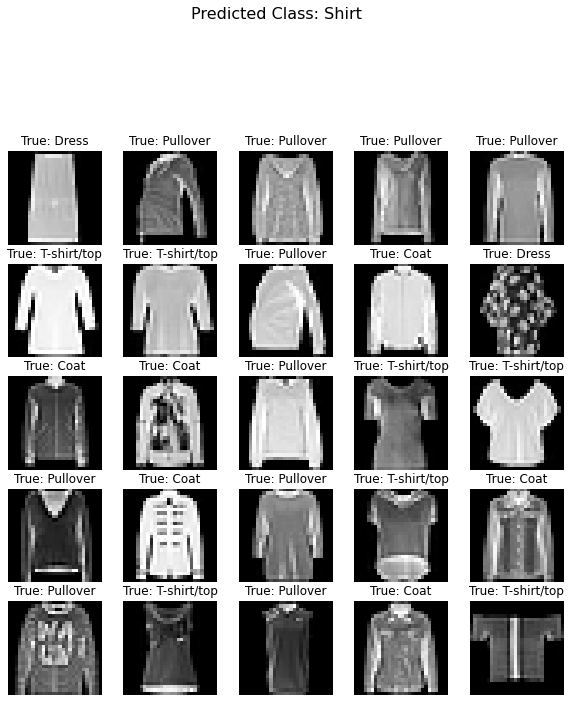

In [50]:
show_FP(x_test,labels, y_pred, 6)

정말 좋은 성적을 거뒀음에도 불구하고 최대한 빨리 손실을 줄이고 있지는 않은 것 같습니다! <br>우리는 더 나은 학습률을 찾을 수 있다.

# **이상적인 학습률 찾기**

LearningRate Scheduler를 사용하여 epoch에 따라 Learning_Rate를 변화시킵니다.<br>
Logspace에서 1e-3에서 1e-2로 천천히 증가

## Making the LearningRateScheduler

In [51]:
from tensorflow.keras import callbacks

num_epochs = 20
lr_epochvals = np.logspace(-4, -2, num_epochs)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: lr_epochvals[epoch])

## Fitting the model (smaller sample)

In [53]:
model = tf.keras.models.clone_model(model)
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam())
sample_size = 10000
history_lr = model.fit(np.expand_dims(x_train, -1)[:sample_size], y_train[:sample_size], 
                       batch_size=128, epochs=num_epochs, callbacks=[lr_scheduler], verbose=0)

## Learning rate vs epoch plot

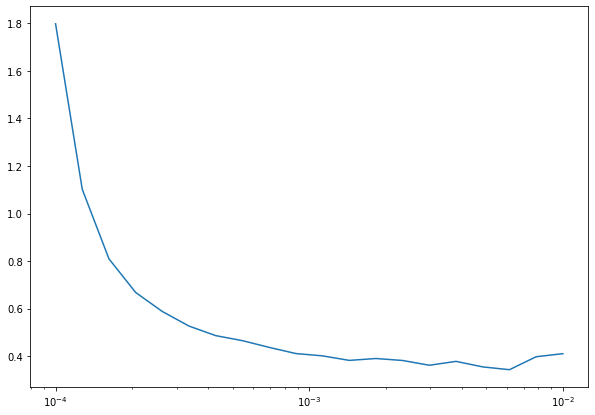

In [54]:
history_lr_df = pd.DataFrame(history_lr.history)

plt.figure(figsize=(10, 7))
plt.semilogx(history_lr_df['lr'], history_lr_df['loss'])

The loss is decreasing fastest somewhere between  10−4 , and first xtick after.

## Refit the model with ideal learning_rate
이상적인 학습 속도로 모델을 장착

In [57]:
best_lr = 1e-4 + (1e-4)*1/2
best_lr
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=best_lr), metrics=['accuracy'])
history = model.fit(x_train,  y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=1)

Epoch 1/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2441 - accuracy: 0.9114 - val_loss: 0.3107 - val_accuracy: 0.8883
Epoch 2/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2408 - accuracy: 0.9122 - val_loss: 0.3121 - val_accuracy: 0.8895
Epoch 3/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2380 - accuracy: 0.9128 - val_loss: 0.3101 - val_accuracy: 0.8882
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2354 - accuracy: 0.9142 - val_loss: 0.3074 - val_accuracy: 0.8912
Epoch 5/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2329 - accuracy: 0.9155 - val_loss: 0.3082 - val_accuracy: 0.8908
Epoch 6/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2297 - accuracy: 0.9168 - val_loss: 0.3135 - val_accuracy: 0.8890
Epoch 7/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2273 - accuracy: 0.9168 - val_loss: 0.3092 - val_accuracy: 0.8922
Epoch 

## Plot the learning curve

척도 때문에 OverFit, 증폭된 것처럼 보이지만 모형이 이전 모형보다 더 잘 수행되거나 그렇지 않을 수 있습니다.<br> (각 실행의 변경 사항!)

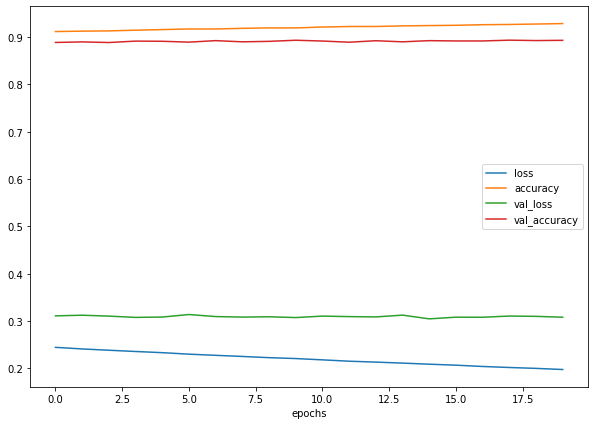

In [58]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");


# **Evaluate the predictions**

### Predictions
* 일반적으로 확률이 가장 높은 클래스는 예측 클래스입니다<br>(각 클래스에 대해 서로 다른 임계값을 설정할 수 있습니다).

In [59]:
y_pred_prob_test = model.predict(np.expand_dims(x_test, -1))
y_pred_test = y_pred_prob_test.argmax(axis=1)
y_pred_test.shape, y_test.shape

((10000,), (10000, 10))

### Confusion matrix

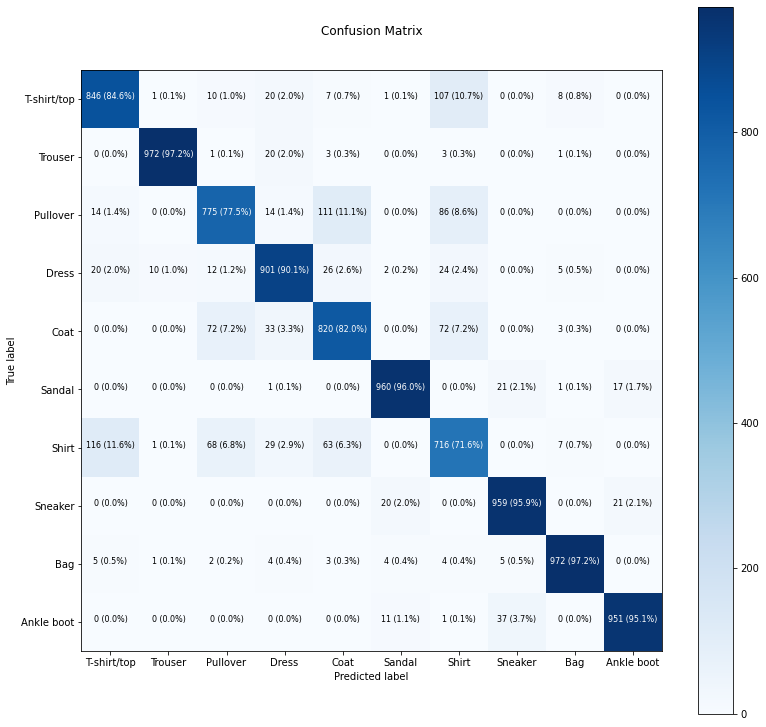

In [60]:
labels = y_test.argmax(axis=1)
ax = make_confusion_matrix(labels, y_pred_test, classes=class_names, figsize=(13, 13), text_size=8)

### Classification metrics

In [61]:
print(classification_report(labels, y_pred_test, target_names=class_names, output_dict=False))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.78      0.80      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.79      0.82      0.81      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.71      0.72      0.71      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

